# Full-fine tuning BERT



In [1]:
! pip install -q "datasets==2.15.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2023.10.0 which is incompatible.


In [2]:
# Load the sms_spam dataset
# See: https://huggingface.co/datasets/sms_spam

from datasets import load_dataset

# The sms_spam dataset only has a train split, so we use the train_test_split method to split it into train and test
dataset = load_dataset("sms_spam", split="train").train_test_split(
    test_size=0.2, shuffle=True, seed=23
)

splits = ["train", "test"]

# View the dataset characteristics
dataset["train"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]

Dataset({
    features: ['sms', 'label'],
    num_rows: 4459
})

Let's look at the first example!

In [3]:
# Inspect the first example. Do you think this is spam or not?
dataset["train"][0]

{'sms': 'Had your mobile 10 mths? Update to the latest Camera/Video phones for FREE. KEEP UR SAME NUMBER, Get extra free mins/texts. Text YES for a call\n',
 'label': 1}

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Let's use a lambda function to tokenize all the examples
tokenized_dataset = {}
for split in splits:
    tokenized_dataset[split] = dataset[split].map(
        lambda x: tokenizer(x["sms"], truncation=True), batched=True
    )

# Inspect the available columns in the dataset
tokenized_dataset["train"]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/4459 [00:00<?, ? examples/s]

Map:   0%|          | 0/1115 [00:00<?, ? examples/s]

Dataset({
    features: ['sms', 'label', 'input_ids', 'attention_mask'],
    num_rows: 4459
})

When you load the model using AutoModelForSequenceClassification or directly with DistilBertForSequenceClassification, Hugging Face internally adds the classification layers on top of the pre-trained DistilBERT architecture. These layers consist of:

pre_classifier: A linear layer (fully connected layer) that takes the output from the DistilBertModel and projects it to a hidden layer with 768 features.

classifier: Another linear layer that maps the 768-dimensional output from the pre_classifier layer to the desired number of labels. In your case, this is 2 labels (spam and not spam).

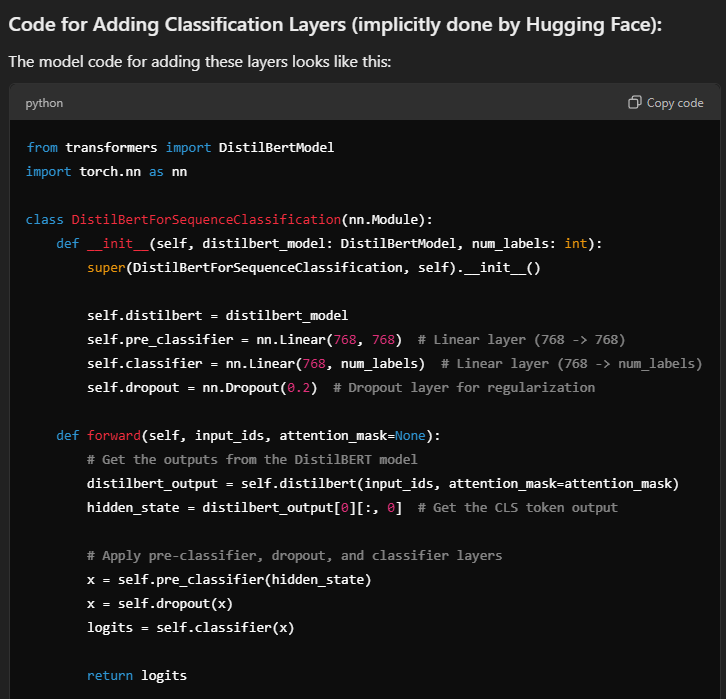

In [5]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    id2label={0: "not spam", 1: "spam"},
    label2id={"not spam": 0, "spam": 1},
)

# Unfreeze all the model parameters.
# Hint: Check the documentation at https://huggingface.co/transformers/v4.2.2/training.html
for param in model.parameters():
    param.requires_grad = True

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [7]:
import torch
import numpy as np
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments

# Check for GPU and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the GPU
model = model.to(device)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

# The HuggingFace Trainer class handles the training and eval loop for PyTorch for us.
# It automatically moves data to the appropriate device.

## Trainer Automatically Handles Devices:
# The Trainer uses the device specified for the model (cuda or cpu) and moves data accordingly during training and evaluation.

trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir="./data/spam_not_spam",  # Directory for saving model checkpoints
        learning_rate=2e-5,                # Learning rate
        per_device_train_batch_size=16,   # Training batch size
        per_device_eval_batch_size=32,    # Evaluation batch size
        evaluation_strategy="epoch",      # Evaluate after each epoch
        save_strategy="epoch",            # Save the model after each epoch
        num_train_epochs=2,               # Number of epochs
        weight_decay=0.01,                # Weight decay for regularization
        load_best_model_at_end=True,      # Load the best model at the end of training
    ),
    train_dataset=tokenized_dataset["train"],  # Hugging Face Trainer moves data to GPU
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

trainer.train()


Using device: cuda


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-7-168c1f5e7faf>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.045696,0.987444
2,0.052500,0.051393,0.989238


TrainOutput(global_step=558, training_loss=0.04994868441721872, metrics={'train_runtime': 89.2522, 'train_samples_per_second': 99.919, 'train_steps_per_second': 6.252, 'total_flos': 144666559425588.0, 'train_loss': 0.04994868441721872, 'epoch': 2.0})

## Evaluate the model

Evaluating the model is as simple as calling the evaluate method on the trainer object. This will run the model on the test set and compute the metrics we specified in the compute_metrics function.

In [8]:
# Show the performance of the model on the test set
# What do you think the evaluation accuracy will be?
trainer.evaluate()

{'eval_loss': 0.04569626972079277,
 'eval_accuracy': 0.9874439461883409,
 'eval_runtime': 2.8376,
 'eval_samples_per_second': 392.933,
 'eval_steps_per_second': 12.334,
 'epoch': 2.0}

### View the results

Let's look at a few examples

In [9]:
# Make a dataframe with the predictions and the text and the labels
import pandas as pd

items_for_manual_review = tokenized_dataset["test"].select(
    [0, 1, 22, 31, 43, 292, 448, 487]
)

results = trainer.predict(items_for_manual_review)
df = pd.DataFrame(
    {
        "sms": [item["sms"] for item in items_for_manual_review],
        "predictions": results.predictions.argmax(axis=1),
        "labels": results.label_ids,
    }
)
# Show all the cell
pd.set_option("display.max_colwidth", None)
df

,sms,predictions,labels
0,Yup... Hey then one day on fri we can ask miwa and jiayin take leave go karaoke \n,0,0
1,Happy new years melody!\n,0,0
2,PRIVATE! Your 2003 Account Statement for shows 800 un-redeemed S. I. M. points. Call 08715203652 Identifier Code: 42810 Expires 29/10/0\n,1,1
3,URGENT! We are trying to contact U. Todays draw shows that you have won a £800 prize GUARANTEED. Call 09050003091 from land line. Claim C52. Valid 12hrs only\n,1,1
4,I had askd u a question some hours before. Its answer\n,0,0
5,"SMS. ac JSco: Energy is high, but u may not know where 2channel it. 2day ur leadership skills r strong. Psychic? Reply ANS w/question. End? Reply END JSCO\n",0,1
6,"Yun ah.the ubi one say if ü wan call by tomorrow.call 67441233 look for irene.ere only got bus8,22,65,61,66,382. Ubi cres,ubi tech park.6ph for 1st 5wkg days.èn\n",1,0
7,Burger King - Wanna play footy at a top stadium? Get 2 Burger King before 1st Sept and go Large or Super with Coca-Cola and walk out a winner\n,0,1
